# Experimental Setup

This notebook will use the data obtained from [GNFUV Unmanned Surface Vehicles Sensor Data Set 2 Data Set](https://archive.ics.uci.edu/ml/datasets/GNFUV+Unmanned+Surface+Vehicles+Sensor+Data+Set+2). This data set contains eight (2x4) data sets of mobile sensor readings data (humidity, temperature) corresponding to a swarm of four Unmanned Surface Vehicles (USVs) in a test-bed, Athens, Greece.

**Dataset characteristics**: Multivariate and Sequential 

**Attributes**:
* 'device' = USV ID (String)
* 'humidity' = sensed humidity value from the USV sensor (real value)
* temperature' = sensed temperature value from the USV sensor (real value)
* 'experiment' = 1 (constant real value)
* 'time' = the sensing and reporting time (real value)
* 'pi' = Raspberry Pi ID



In [7]:
# Global variable to control if activate all the verbose will be plotted.
debug=False

In [8]:
import os
import json
from datetime import datetime
from json import JSONDecodeError
import pandas as pd
import numpy as np

def generate_dataset(home_dir,dataset_name):
    
    """generate_dataset: This function assumes the data is 
    distributed in folders from a parent directory. 
    Each folder contains comma-separated files where each 
    row is defined with a JSON notation.
    Arguments:
        home_dir [string] -- parent directory
        dataset_name [ [string] ] -- Target folder name
    Returns:
        {data_df} -- Pandas dataframe with all the information joined,
                    cleaned and ready to use.
    """
    home_dir = home_dir +"/" + dataset_name
    pi_dirs = os.listdir(home_dir)
    data_list = []
    columns = None
    
    for pi_dir in pi_dirs:
        if 'pi' not in pi_dir:
            continue
        curr_dir = os.path.join(home_dir, pi_dir)
        data_file = os.path.join(curr_dir, os.listdir(curr_dir)[0])
        with open(data_file, 'r') as f:
            line = f.readline().strip().replace("'", '"')
            while line != '':
                try:
                    input_json = json.loads(line)
                    sensor_datetime = datetime.fromtimestamp(input_json['time'])
                    input_json['time'] = sensor_datetime
                    input_json['pi'] = pi_dir
                    data_list.append(list(input_json.values()))
                    if columns is None:
                        columns = list(input_json.keys())
                except JSONDecodeError as je:
                    pass
                line = f.readline().strip().replace("'", '"')
    
    data_df = pd.DataFrame(data_list, columns=columns)
    
    #@TODO: Include an argument to decide the target columns we want in the final dataset.
    del data_df['experiment']
    del data_df['device']
    del data_df['time']
    del data_df['pi']
    data_df = data_df.replace(to_replace=' None', value=np.nan).dropna()
    return data_df

## Building the dataset

* $D$ is the dataset with all the points.
* *target_columns* are the selected variables for this study ('temperature','humidity').
* if debug is activated, we perform some data checking to see the number of unique values at each column and any null or missing data. The function ```generate_dataset()```must prevent them.

In [9]:
home_dir = '../datasets'
dataset = 'GNFUV-USV-Dataset'

# This variable contains the name of the columns and represents the variables we want to study
xvar='temperature'
yvar='humidity'
target_columns=[xvar,yvar]

# D represents the global dataset (all the points).
D = generate_dataset(home_dir,dataset)

if debug:
    for t in target_columns:
        print(D[t].value_counts())
    print("Checking if there are any null or NAN value:")
    print(D.isnull().any())
    print((D.isnull().sum()/len(D.index))*100)
    

### Distribution of $D$

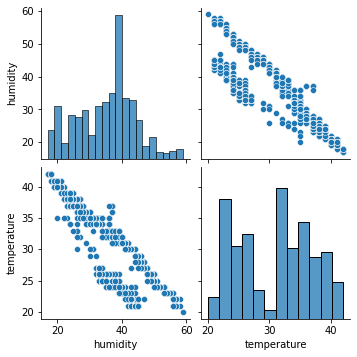

In [10]:
import seaborn as sns
# Plot the distribution (2D)
sns.pairplot(D, height=2.5);

## Outliers of $D$

<AxesSubplot:>

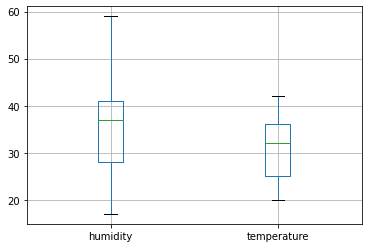

In [11]:
D.boxplot()

## Standaritzation of $D$ -> $\tilde D$

Make data consitent and normalized. $\tilde D$ is ```D_Scaled``` in the code.

array([[<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'temperature'}>]], dtype=object)

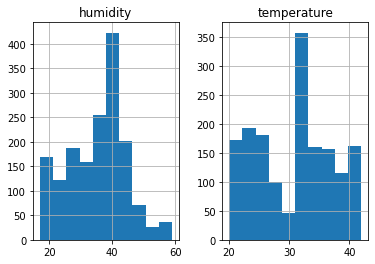

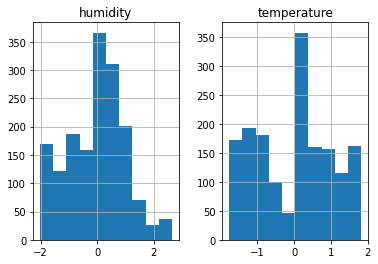

In [12]:
from sklearn.preprocessing import StandardScaler

standaritzation = StandardScaler()
standaritzation.fit(D[target_columns])
scaled=standaritzation.transform(D[target_columns])
D_Scaled = D.copy()
D_Scaled[target_columns] = scaled

D.hist()
D_Scaled.hist()

## Helper functions to train, test and explore models

To test the accuracy and performance of the model we use MSE and RMSE metrics. 

$$MSE = \frac{1}{n} \sum_{i=1}^{D}(y_i - \hat y_i)^2$$ 

where $y_i$ represent the *y-test* set and $\hat y_i$ the *y-predicted* using the model and $n$ the lenght of *y-test*.

$$RMSE = \sqrt(MSE)$$ 

**RMSE**: It represents the standard deviation of prediction errors. How far are the data points from the regression line.

*Note: It is hardcoded to SVR with specific configuration values.*

In [13]:
# Keys
Xtrain="xtrain"
Xtest="xtest"
Ytrain="ytrain"
Ytest="ytest"

def split_data(x,y, test_size=0.2):
    dd={}
    from sklearn.model_selection import train_test_split
    dd[Xtrain],dd[Xtest],dd[Ytrain],dd[Ytest]=train_test_split(x,y,test_size=test_size,random_state=42)
    return dd

def train_model(x_train, y_train, x_test, y_test):
    
    # svr is a support vector regression model
    from sklearn.svm import SVR
    svr = SVR(kernel='rbf', C=1, gamma=0.1, epsilon=0.1)
    model = svr.fit(x_train,y_train)
    score = model.score(x_test,y_test)
    
    if debug:
        print("SCORE:" + str(score))
        
    return model,score

def test_model(model,x_test,y_test):
    
    from sklearn.metrics import mean_squared_error
    from numpy import sqrt
    
    predictions = model.predict(x_test)
    y_predicted = pd.DataFrame(predictions, columns=['predicted'])
    
    mse = mean_squared_error(y_test, y_predicted)
    rmse = sqrt(mse)
    
    if debug:
        print("MSE:", mse)
        print("RMSE:", rmse)
    
    return mse,rmse,y_predicted

def plot_model(x_test,y_test,y_predicted,name='', x_name='x',y_name='y'):

    import matplotlib.pyplot as plt
    
    plt.scatter(x_test, y_test, c='tab:green', label='original')
    plt.plot(x_test, y_predicted, c='tab:red', label='predicted')
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Support Vector Regression ' +str(name))
    plt.legend()
    plt.show()
    

## Model $M$

Model with name M is the big brother. This model is trained using the whole training set belonging to $D$ or to $\tilde D$.

```models={}``` is a dictionary that contains information about a specific model, where name is the model name (i.e. $M$).

```json
name: {
     model: Trained model (SVR)
     score: Score obtained (scalar)
     mse: mean square error (scalar)
     rmse: root mean square error (scalar)
     prediction: y predicted values (Dataframe)
   }
```

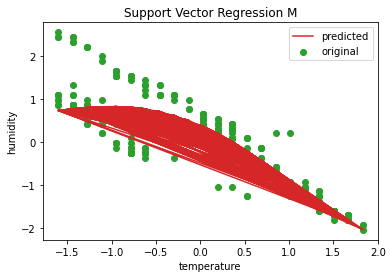

Accuracy of model: M === 75.52% (nº of correct predictions)"
Performance of model: M === 0.26 (MSE)
How far are the data points from the regression line: M === 0.51 (RMSE)


In [14]:
# _D represents a dictionary with the train and test data
X = D_Scaled.copy().drop(columns=[yvar])
y = D_Scaled[yvar].copy()
_D = split_data(X,y,test_size=0.2)

M="M"
models={}
models[M]={}
models[M]["model"],models["M"]["score"]= train_model(_D[Xtrain],_D[Ytrain],_D[Xtest],_D[Ytest])
models["M"]["mse"],models["M"]["rmse"],models["M"]["prediction"]=test_model(models["M"]["model"],_D[Xtest],_D[Ytest])
plot_model(_D[Xtest],_D[Ytest],models["M"]["prediction"],"M",xvar,yvar)

print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(M, models["M"]["score"]*100))
print('Performance of model: {} === {:.2f} (MSE)'.format(M, models["M"]["mse"]))
print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(M, models["M"]["rmse"]))

### Helpers to Data generation
This section aims to prepare the dataset to work with. The idea is to split the dataset into different groups to represent a node in our edge layer.

So, we want to represent our edge layer as a set of nodes ($n \in N$).
Each node $n$ in the edge layer will contain a unique subset of points from the full dataset $D$. Therefore, $D_{n}\subset D \;,\; \forall n \in N\;|\; D_n\not\subset D_m\;, \; \forall m \in N \;, \;m \neq n$.

This way, we use **KMeans** to generate different clusters and assign each cluster to a different node. *Note*: $K=N$

```generate_data```return a list of centroids and a dictionary $\hat D$:
```json
n0: {
     full: Dataframe 
     split: { 
         xtrain: Dataframe
         xtest: Dataframe
         ytrain: Dataframe
         ytest: Dataframe
     }
   },
nK: {
     full: Dataframe
     split: { 
         xtrain: Dataframe
         xtest: Dataframe
         ytrain: Dataframe
         ytest: Dataframe
     }
   }
```

In [15]:
# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt
from sklearn.cluster import KMeans

def generate_data(dataset,n_clusters,x_name,y_name):
    from pandas import DataFrame
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters).fit(dataset)
    centroids = kmeans.cluster_centers_
    
    # We build a dictionary for each cluster with the corresponding dataframe using the position obtained in Kmeans
    # We split the x,y into train and test sets
    
    datasets = {}
    
    samples = {kmeans.cluster_centers_[i, 0]: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

    nodes_index=0
    for k in samples.keys():
        datasets["n"+str(nodes_index)]={}
        d = dataset.iloc[samples[k], :]
        
        X=d.copy().drop(columns=[yvar])
        y=d[yvar].copy()
        
        datasets["n"+str(nodes_index)]["full"] = d
        datasets["n"+str(nodes_index)]["split"] = split_data(X,y,test_size=0.2)
        nodes_index = nodes_index +1
        
    return centroids, datasets, kmeans
    

def plot_nodes(dataset,centroids,x_name,y_name,kmeans):
    import matplotlib.pyplot as plt
    labels = ['n{0}'.format(i) for i in range(len(centroids))]
    plt_data = plt.scatter(dataset[x_name], dataset[y_name], c= kmeans.labels_.astype(float))
    plt.colorbar()
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x')
    plt.title('K-means clustering')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    labels = ['n{0}'.format(i) for i in range(K)]
    for i in range (K):
        xy=(centroids[i, 0],centroids[i, 1])
        plt.annotate(labels[i],xy, horizontalalignment='right', verticalalignment='top',
              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.95', 
                                color='b'))

    plt.show()    

### Data Generation

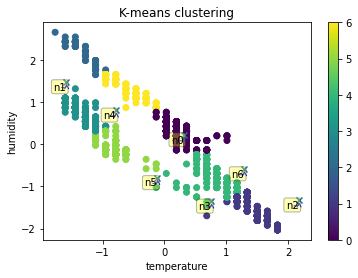

In [16]:
K=7
centroids,D_,kmeans = generate_data(D_Scaled,K,xvar,yvar)

if debug:
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(D_)
    

plot_nodes(D_Scaled,centroids,xvar,yvar,kmeans)


### Distribution of $\hat D$

$\hat D$ represents the dictonary that contains the data at each node. For each node we have (full and split data).

Let us check the different distributions of each node concerning the two variables studied, humidity and temperature.

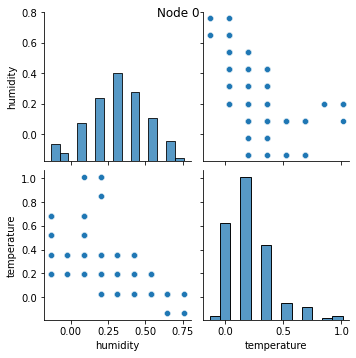

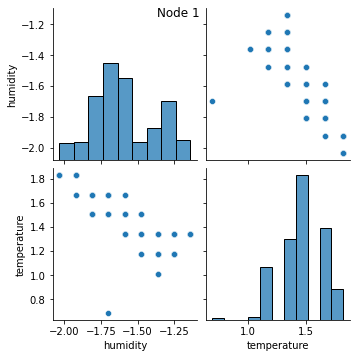

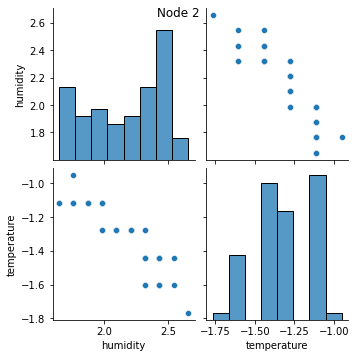

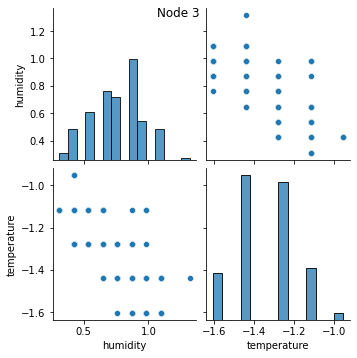

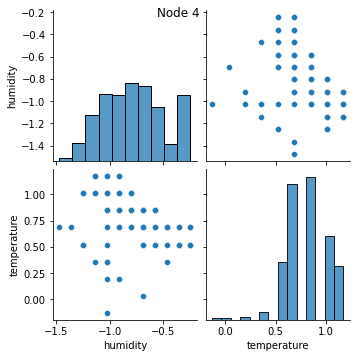

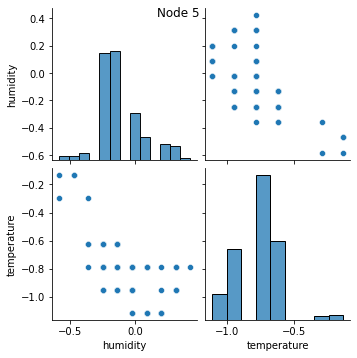

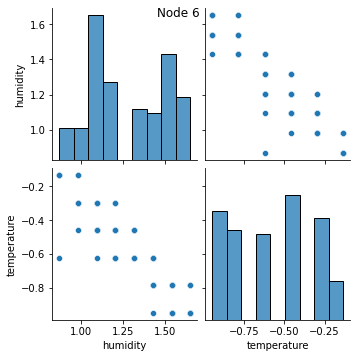

In [17]:
i=0
for k in D_.keys():
    g = sns.pairplot(D_[k]["full"], height=2.5);
    g.fig.suptitle("Node "+str(i)) 
    i=i+1

# Generating the models $m_i$

We are going to add to ```models``` dictionary a new model for each $N$ dataset. Therefore, $m_i \; | \; \forall i \in N$:

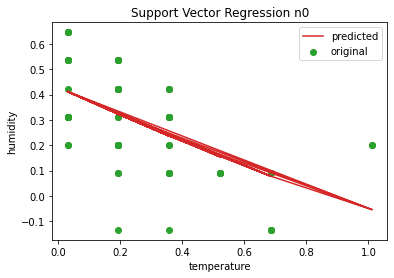

Accuracy of model: n0 === 31.80% (nº of correct predictions)"
Performance of model: n0 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.16 (RMSE)


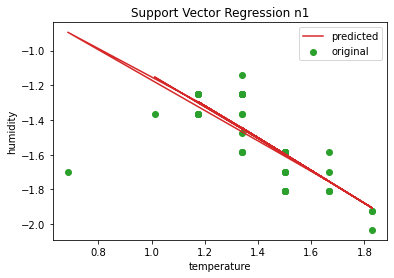

Accuracy of model: n1 === 45.23% (nº of correct predictions)"
Performance of model: n1 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.17 (RMSE)


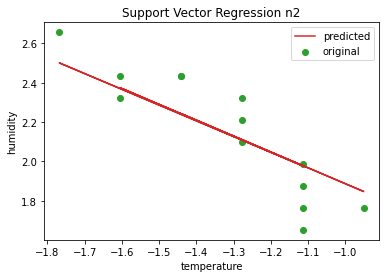

Accuracy of model: n2 === 73.01% (nº of correct predictions)"
Performance of model: n2 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.16 (RMSE)


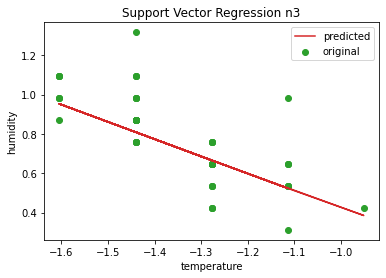

Accuracy of model: n3 === 51.32% (nº of correct predictions)"
Performance of model: n3 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.15 (RMSE)


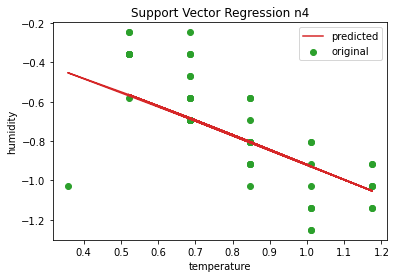

Accuracy of model: n4 === 53.02% (nº of correct predictions)"
Performance of model: n4 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.18 (RMSE)


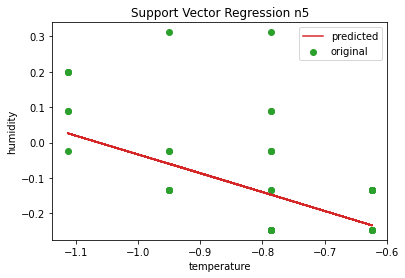

Accuracy of model: n5 === 25.50% (nº of correct predictions)"
Performance of model: n5 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.14 (RMSE)


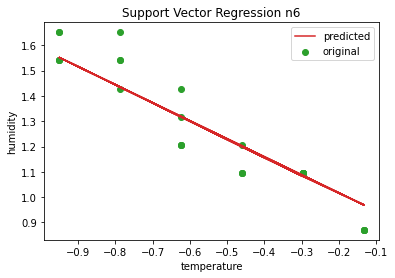

Accuracy of model: n6 === 88.22% (nº of correct predictions)"
Performance of model: n6 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.09 (RMSE)


In [18]:
index_model=0

for k in D_.keys():
    
    # ni is the node i
    ni = "n"+str(index_model)
    
    # di is the dataset corresponding to node i
    di=D_["n"+str(index_model)]["split"]
    
    models[ni]={}
    models[ni]["model"],models[ni]["score"] = train_model(di[Xtrain],di[Ytrain],di[Xtest],di[Ytest])
    models[ni]["mse"],models[ni]["rmse"],models[ni]["prediction"]=test_model(models[ni]["model"],di[Xtest],di[Ytest])
    plot_model(di[Xtest],di[Ytest],models[ni]["prediction"],ni,xvar,yvar)


    print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(ni, models[ni]["score"]*100))
    print('Performance of model: {} === {:.2f} (MSE)'.format(ni, models[ni]["mse"]))
    print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(M, models[ni]["rmse"]))

    index_model = index_model +1

In [28]:
def generate_outsiders(datasets,strategy,outer):
    import copy
    output={}
    if (strategy == 'percentile' or strategy == 'random'):
        percentile = ((100/outer)/100) - 0.01
        
        index_model=0
        for k in datasets.keys():
            # ni is the node i
            ni = "n"+str(index_model)
            # di is the dataset corresponding to node i
            di=datasets[ni]

            output[ni]= copy.deepcopy(di)

            index_outer_model = 0
            for ko in datasets.keys():
                # nko is the node ko
                nko = "n"+str(index_outer_model)
                # dko is the dataset corresponding to node ko
                dko = datasets[nko]
                
                if (index_model != index_outer_model):
                    
                    nx=output[ni]["split"][Xtrain].values.tolist()
                    ny=output[ni]["split"][Ytrain].values.tolist()
                    
                    for o in range(outer):
                        if (strategy == 'percentile'):
                            v =  percentile + (percentile*o)
                            vDf = pd.DataFrame(dko["full"].quantile(v)).T
                        elif (strategy == 'random'):
                            vDf = pd.DataFrame(dko["full"].sample())
                            
                        nx.append([vDf.iloc[:,1].values[0]])
                        ny.append(vDf.iloc[:,0].values[0])
                    
                    dfx = pd.DataFrame(nx,columns=[xvar])
                    dfy = pd.Series(ny)
                    
                

                            
                    #xt=output[ni]["split"][Xtrain]
                    #yt=output[ni]["split"][Ytrain]
                        
                        #output[ni]["split"][Xtrain]=pd.concat([
                         #   xt, pd.DataFrame(vDf.iloc[:,1].values)],ignore_index=True)
                            
                        #xt.loc[len(xt.index)] = vDf.iloc[:,1].values[0].copy()
                        #yt.loc[len(yt.index)] = vDf.iloc[:,0].values[0].copy()
                    #del output[ni]["split"][Xtrain]
                    #del output[ni]["split"][Ytrain]
                    output[ni]["split"][Xtrain] = dfx.copy()
                    output[ni]["split"][Ytrain] = dfy.copy()
                
                index_outer_model = index_outer_model +1
            index_model = index_model + 1
                                      
    else:
        raise ValueError("Wrong strategy. Strategy must be ['random','percentile']")
             
    return output


In [29]:
outers = 5
#print(len(D_['n0']["split"][Xtrain]))
data=D_.copy()
DO_=generate_outsiders(data,'percentile',outers)
#print(len(D_['n0']["split"][Xtrain]))
#print(len(DO_['n0']["split"][Xtrain]))

print(type(D_['n0']["split"][Xtrain]))
print(type(DO_['n0']["split"][Xtrain]))
print((D_['n0']["split"][Ytrain]))
print((DO_['n0']["split"][Ytrain]))

print("+++ Testing generate_outsiders():")

index_model=0
for k in D_.keys():
    # ni is the node i
    ni = "n"+str(index_model)
    # di is the dataset corresponding to node i
    di=D_[ni]
    # di is the dataset with outsider corresponding to node i
    doi=DO_[ni]
    
    if (len(di["split"][Xtrain]) + (K-1) * outers == len(doi["split"][Xtrain])):
        print("Passed in node {} (Xtrain) -> {} != {}".format(index_model,
              len(di["split"][Xtrain])  + (K-1) * outers,
              len(doi["split"][Xtrain]))
            )
    else:
        print("Error in node {} (Xtrain) -> {} == {}".format(index_model,
              len(di["split"][Xtrain]) + (K-1) * outers,
              len(doi["split"][Xtrain]))
            )
    if (len(di["split"][Ytrain]) + (K-1) * outers == len(doi["split"][Ytrain])):
        print("Passed in node {} (Ytrain) -> {} != {}".format(index_model, 
              len(di["split"][Ytrain] ) + (K-1) * outers,
              len(doi["split"][Ytrain]))
            )
    else:
        print("Error in node {} (Ytrain)-> {} == {}".format(index_model,
              len(di["split"][Ytrain]) + (K-1) * outers,
              len(doi["split"][Ytrain]))
            )
    
    index_model = index_model + 1 

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
1585    0.423474
1438    0.200122
1428    0.200122
1116    0.423474
1597    0.311798
          ...   
1124    0.311798
1159    0.088447
1526    0.535150
1604    0.200122
1155    0.200122
Name: humidity, Length: 314, dtype: float64
0      0.423474
1      0.200122
2      0.200122
3      0.423474
4      0.311798
         ...   
339    1.093529
340    1.205205
341    1.316880
342    1.540232
343    1.651908
Length: 344, dtype: float64
+++ Testing generate_outsiders():
Passed in node 0 (Xtrain) -> 344 != 344
Passed in node 0 (Ytrain) -> 344 != 344
Passed in node 1 (Xtrain) -> 227 != 227
Passed in node 1 (Ytrain) -> 227 != 227
Passed in node 2 (Xtrain) -> 82 != 82
Passed in node 2 (Ytrain) -> 82 != 82
Passed in node 3 (Xtrain) -> 263 != 263
Passed in node 3 (Ytrain) -> 263 != 263
Passed in node 4 (Xtrain) -> 286 != 286
Passed in node 4 (Ytrain) -> 286 != 286
Passed in node 5 (Xtrain) -> 182 != 182
Passed in node 5 (Y

## Training the models with outsiders

We train the models using the new datasets including outsiders.

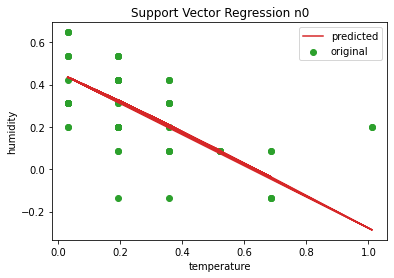

Accuracy of model: n0 === 22.32% (nº of correct predictions)"
Performance of model: n0 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.17 (RMSE)


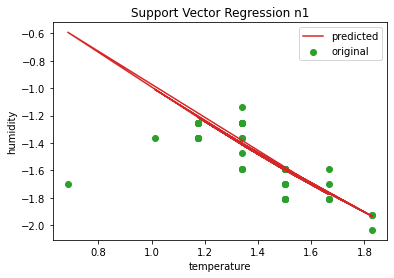

Accuracy of model: n1 === 19.36% (nº of correct predictions)"
Performance of model: n1 === 0.04 (MSE)
How far are the data points from the regression line: M === 0.21 (RMSE)


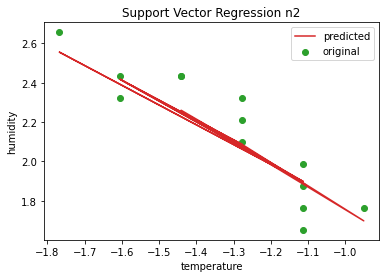

Accuracy of model: n2 === 80.04% (nº of correct predictions)"
Performance of model: n2 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.14 (RMSE)


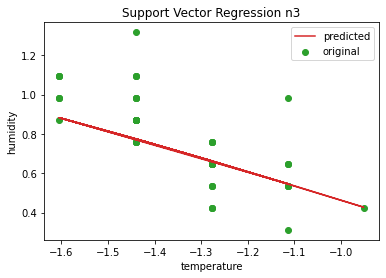

Accuracy of model: n3 === 40.83% (nº of correct predictions)"
Performance of model: n3 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.17 (RMSE)


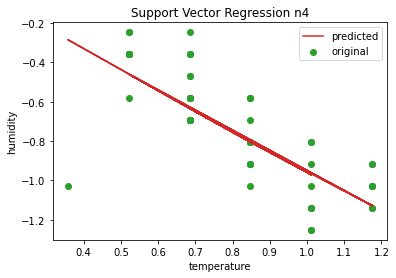

Accuracy of model: n4 === 58.86% (nº of correct predictions)"
Performance of model: n4 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.17 (RMSE)


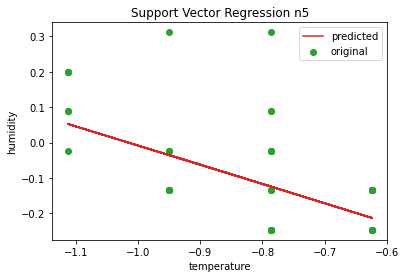

Accuracy of model: n5 === 33.04% (nº of correct predictions)"
Performance of model: n5 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.13 (RMSE)


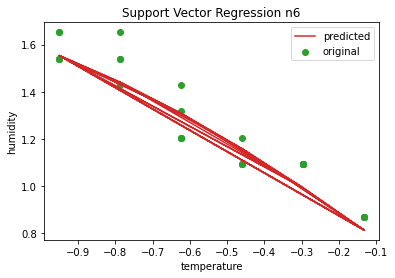

Accuracy of model: n6 === 87.33% (nº of correct predictions)"
Performance of model: n6 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.09 (RMSE)


In [30]:
index_model=0
models_outsiders={}
for k in DO_.keys():
    
    # ni is the node i
    ni = "n"+str(index_model)
    # doi is the dataset corresponding to node i
    doi=DO_[ni]["split"]

    
    models_outsiders[ni]={}
    models_outsiders[ni]["model"],models_outsiders[ni]["score"] = train_model(doi[Xtrain],doi[Ytrain],doi[Xtest],doi[Ytest])
    models_outsiders[ni]["mse"], models_outsiders[ni]["rmse"], models_outsiders[ni]["prediction"] = test_model(models_outsiders[ni]["model"],doi[Xtest],doi[Ytest])
    plot_model(doi[Xtest],doi[Ytest],models_outsiders[ni]["prediction"],ni,xvar,yvar)


    print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(ni, models_outsiders[ni]["score"]*100))
    print('Performance of model: {} === {:.2f} (MSE)'.format(ni, models_outsiders[ni]["mse"]))
    print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(M, models_outsiders[ni]["rmse"]))

    index_model = index_model +1

In [39]:
def train_test(d,output,xtest,ytest):
    res={}
    m,score = train_model(d[Xtrain],d[Ytrain],xtest,ytest)
    mse, rmse, ypred = test_model(m,xtest,ytest)
    output.append(mse);
    return output


def do_sa_outer(outersList,ds,_ds):
    experiments={}
    for outer in outersList:
        
        #DO_=generate_outsiders(D_,'percentile',outers)
        
        DO_p = generate_outsiders(ds,'percentile',outer)
        DO_r = generate_outsiders(ds,'random',outer)
        
       
        
        experiments[outer] = {}
        
        
        # Each experiment needs to fix the test data from one node
        for k in ds.keys():
            experiments[outer][k] = {}
            
            eXtest = ds[k]["split"][Xtest]
            eYtest = ds[k]["split"][Ytest]
            
            experiments[outer][k]["full"] = []
            train_test(_ds,experiments[outer][k]['full'],eXtest,eYtest)
            
            experiments[outer][k]["percentile"] = []
            experiments[outer][k]["random"] = []
            experiments[outer][k]["nodes"] = []

            for k1 in ds.keys():

                ni=k1
                
                # Percentil strategy
                di_p=DO_p[ni]["split"]
                train_test(di_p,experiments[outer][k]['percentile'],eXtest,eYtest)
                
                # Random strategy
                di_r=DO_r[ni]["split"]
                train_test(di_r,experiments[outer][k]['random'],eXtest,eYtest)

                # Nodes
                di=ds[ni]["split"]
                train_test(di,experiments[outer][k]['nodes'],eXtest,eYtest)

                
    return experiments

        
        

In [40]:
outersList = [5,7,10,15,17,20,25,30]
#outersList = [15]
experiment1=do_sa_outer(outersList,D_,_D)
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(experiment1)

{   5: {   'n0': {   'full': [0.08002692244116132],
                     'nodes': [   0.024533801798687326,
                                  0.877343604542987,
                                  0.7645255640279015,
                                  0.3962216909900835,
                                  0.4790908831033485,
                                  0.8698468839157876,
                                  0.2324742527075005],
                     'percentile': [   0.027944912855560094,
                                       0.17093582309613506,
                                       0.08757468765261717,
                                       0.5348661784525461,
                                       0.24757391707761292,
                                       0.9036972118686482,
                                       0.057321912641465016],
                     'random': [   0.027967057231364126,
                                   0.1865621300488411,
                                   

            'n3': {   'full': [0.05576246015830667],
                      'nodes': [   0.1166917136308455,
                                   1.7995534283388268,
                                   1.9540684790465481,
                                   0.02250094191448483,
                                   0.5860980135071779,
                                   0.4338628217586283,
                                   1.0942896046971378],
                      'percentile': [   0.07622748213586128,
                                        0.0753545408390427,
                                        0.4828849342635363,
                                        0.028677242922545407,
                                        0.07522610837756807,
                                        0.11733152416140569,
                                        0.7931055669295303],
                      'random': [   0.1008902557212608,
                                    0.2255447392231502,
                      

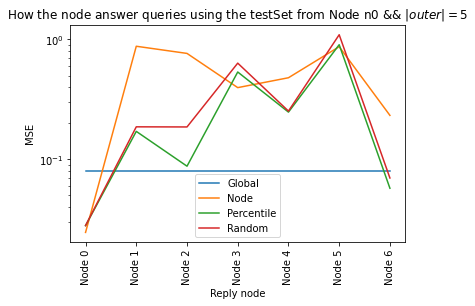

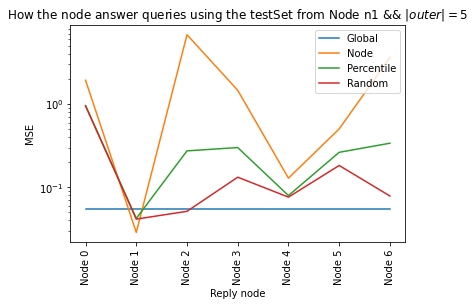

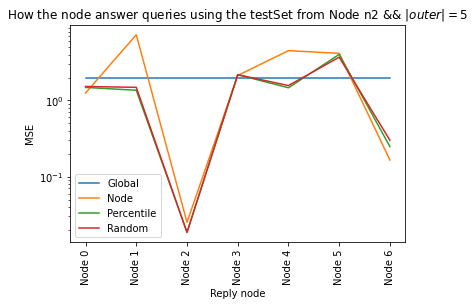

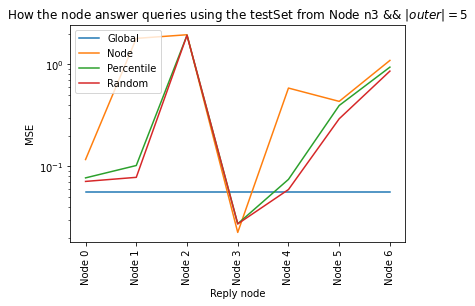

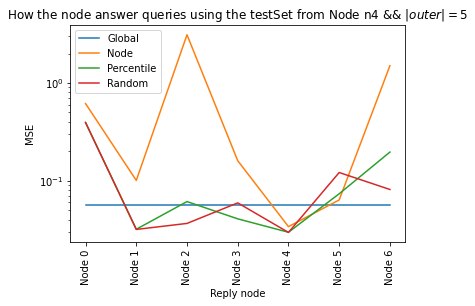

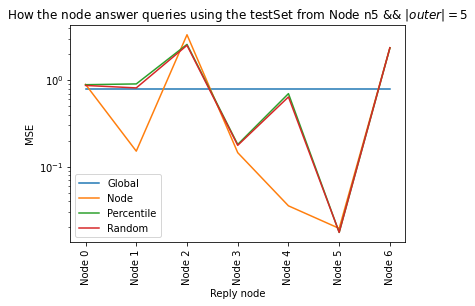

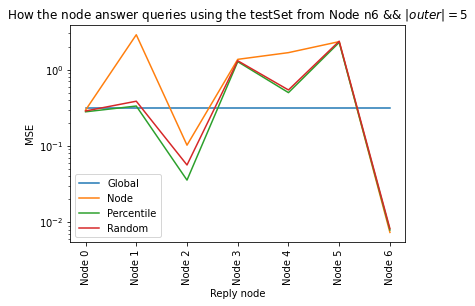

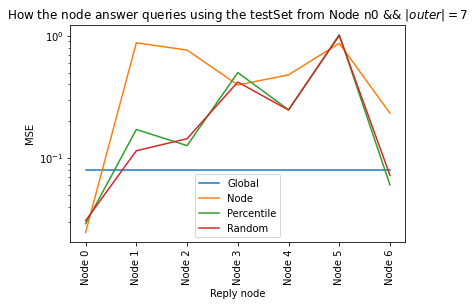

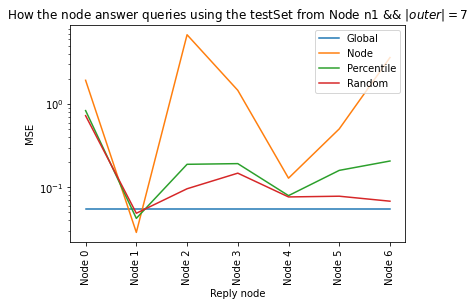

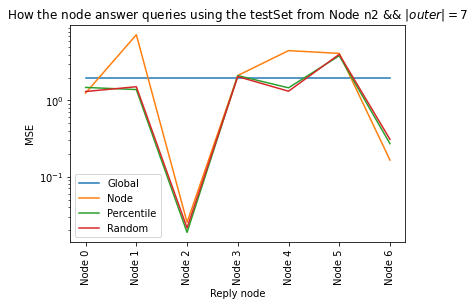

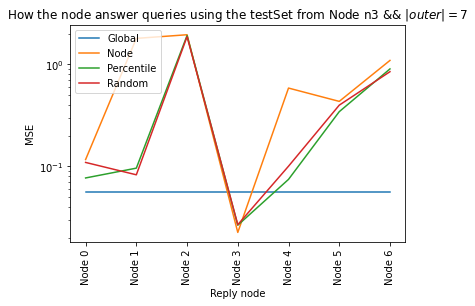

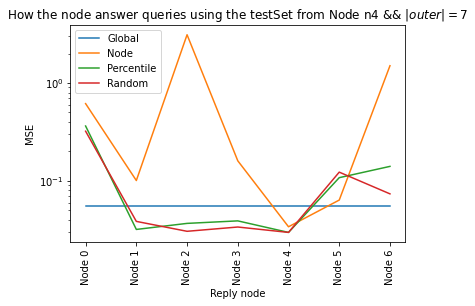

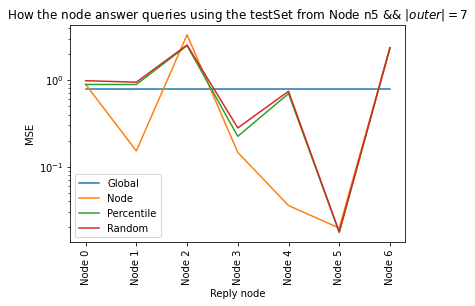

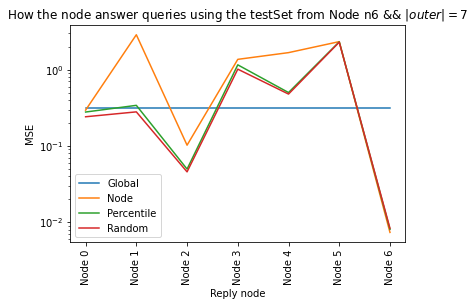

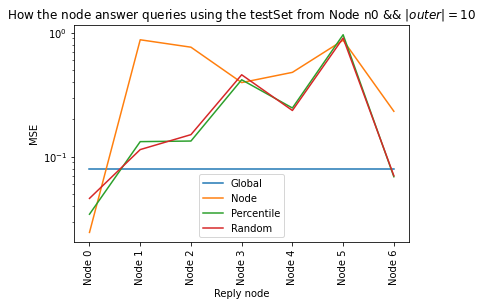

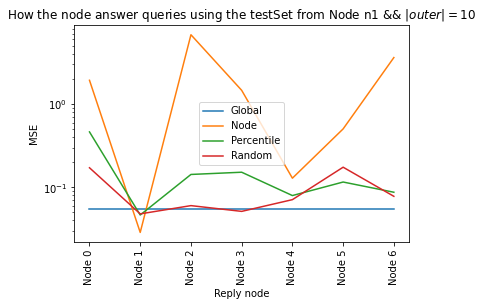

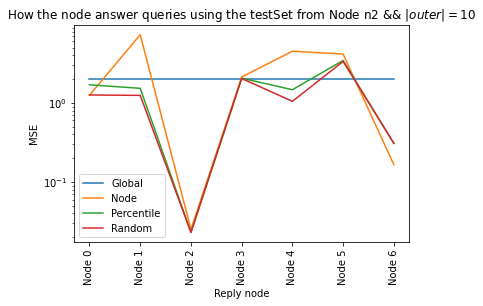

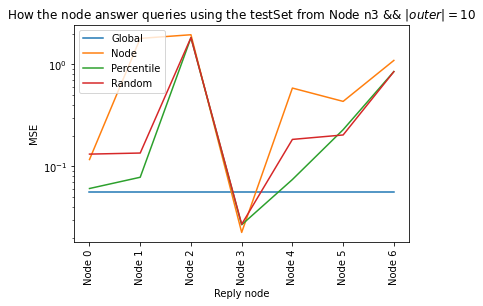

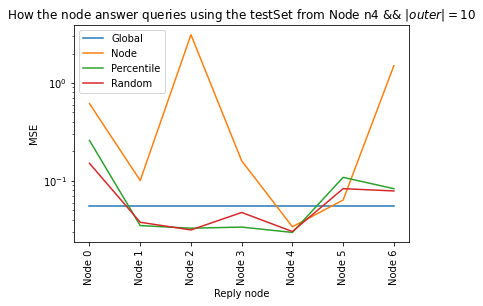

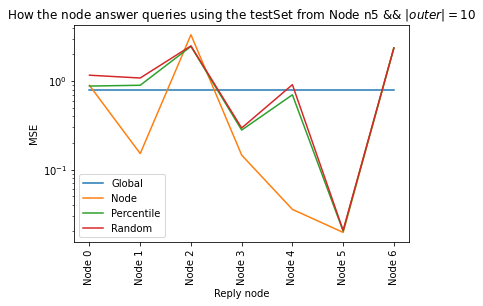

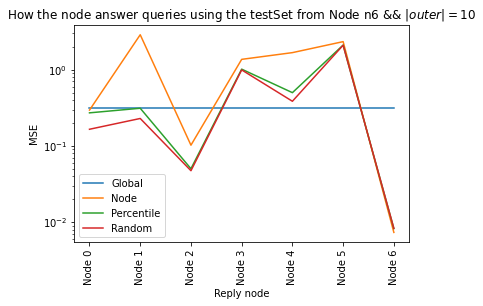

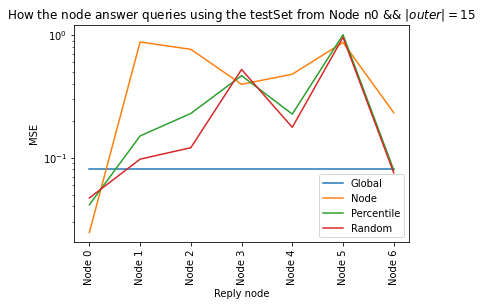

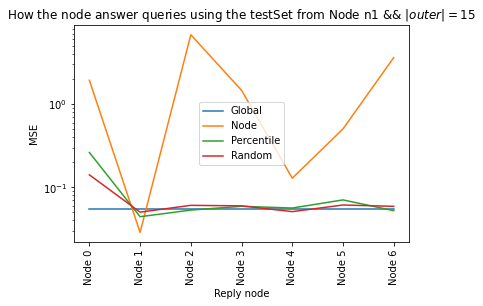

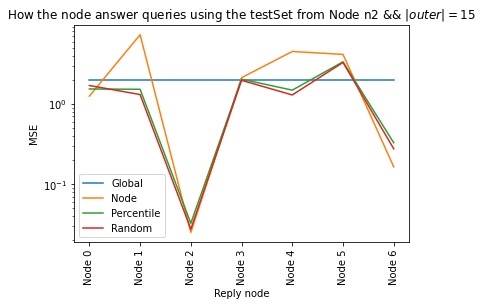

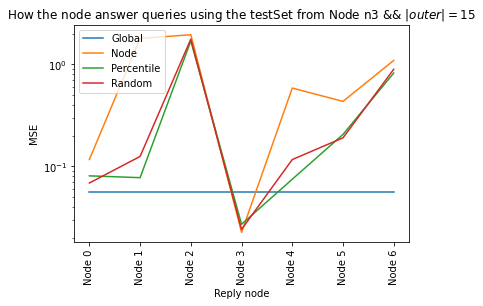

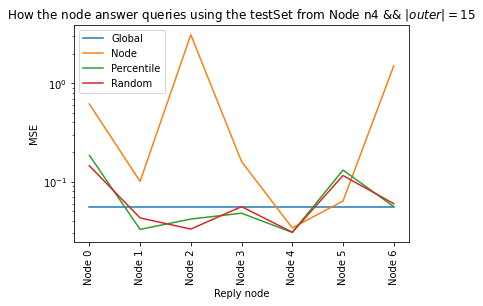

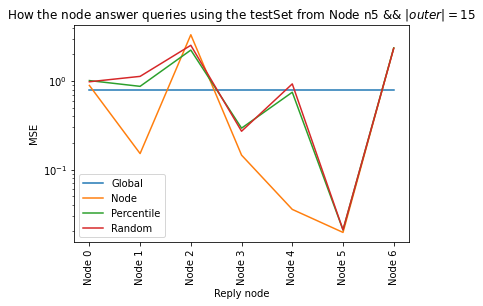

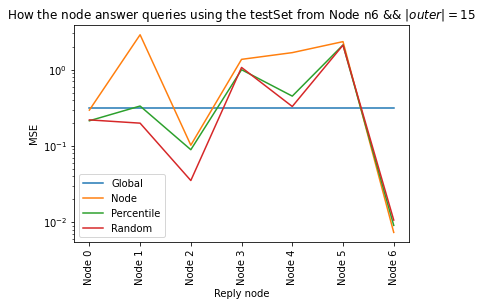

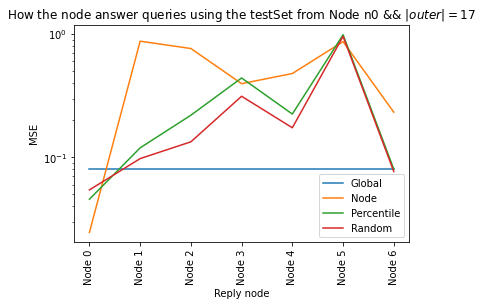

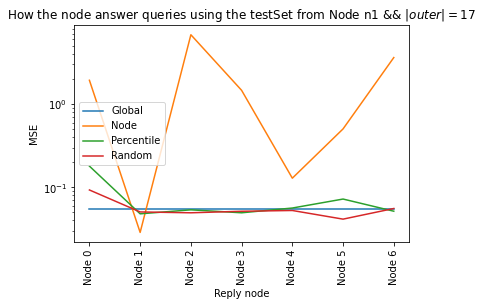

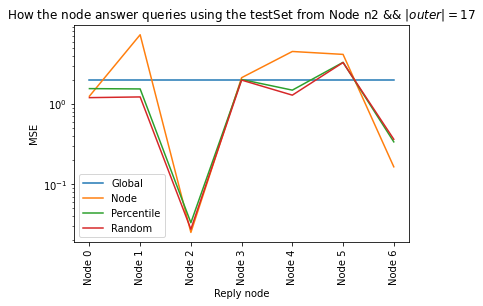

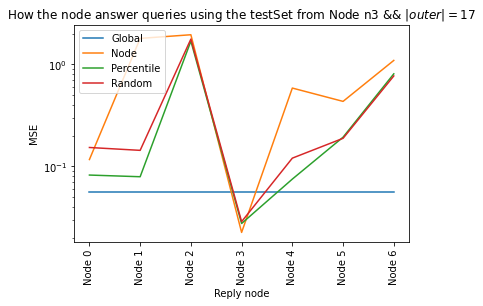

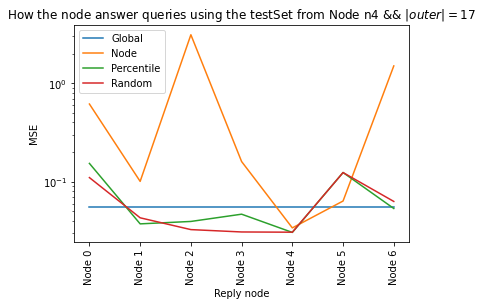

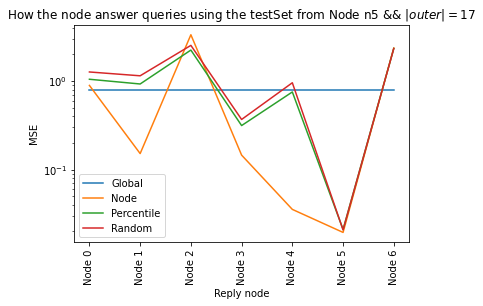

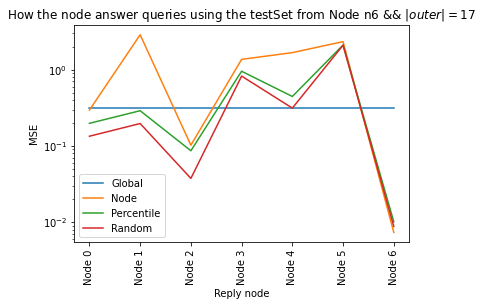

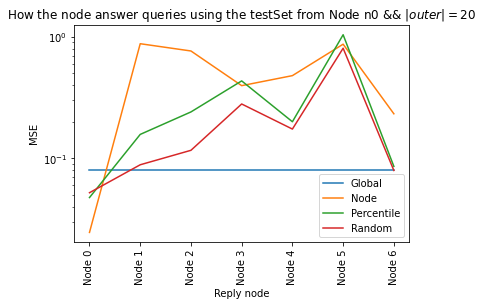

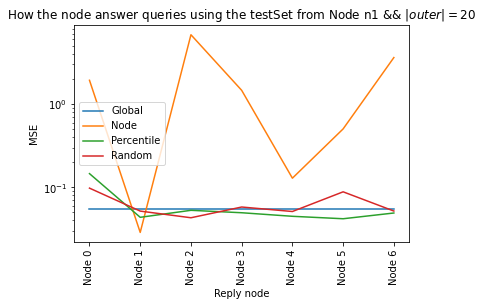

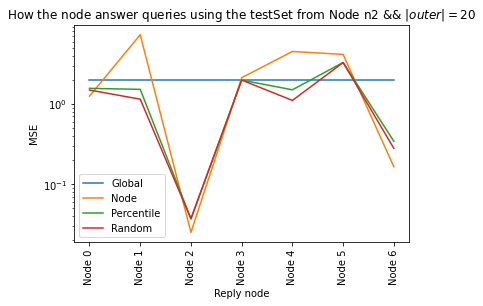

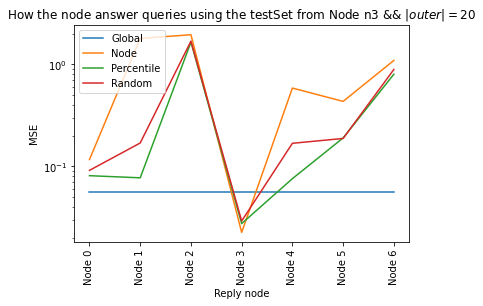

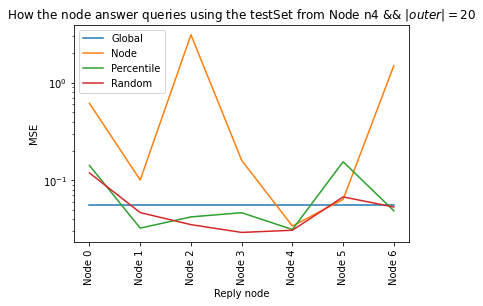

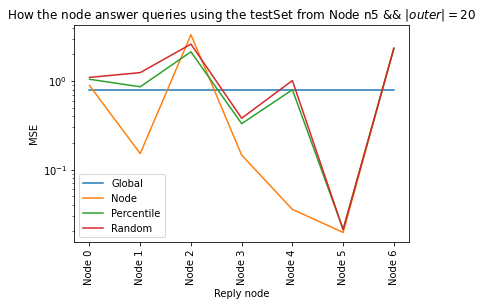

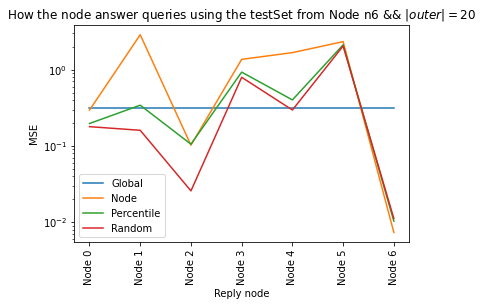

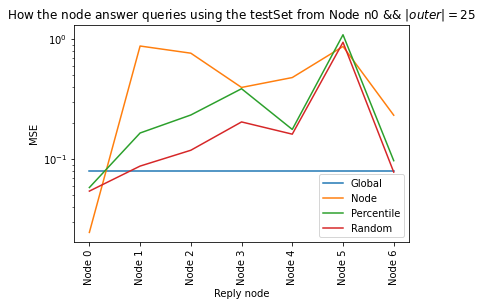

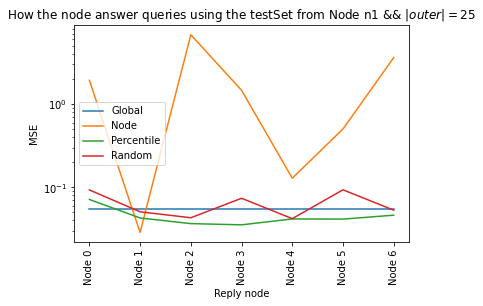

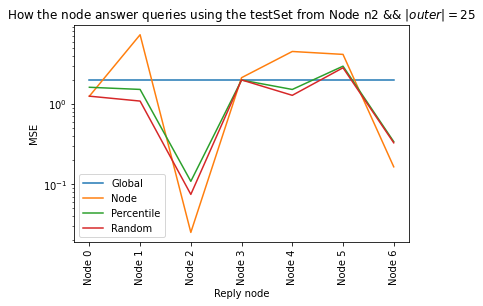

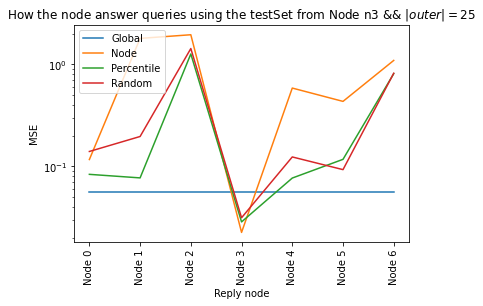

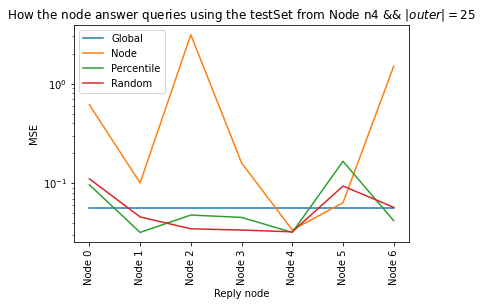

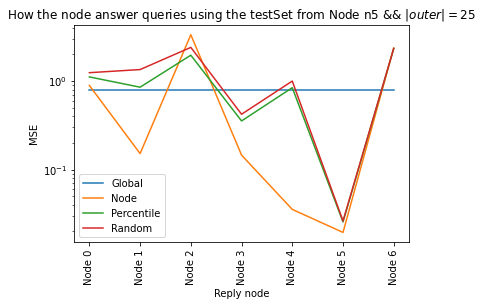

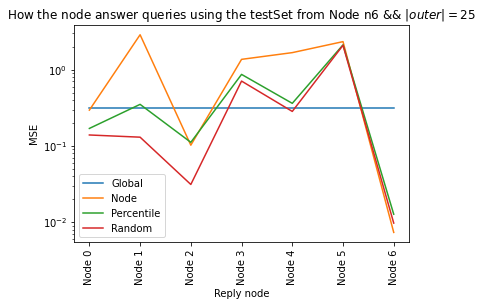

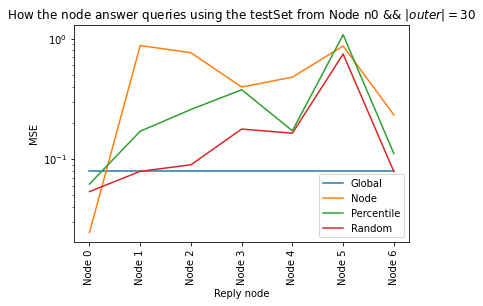

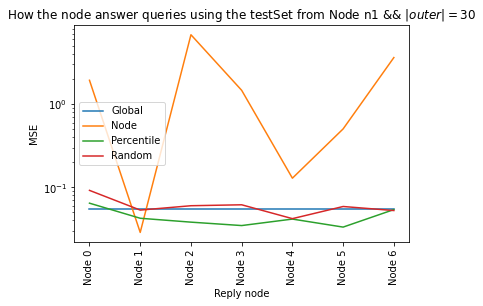

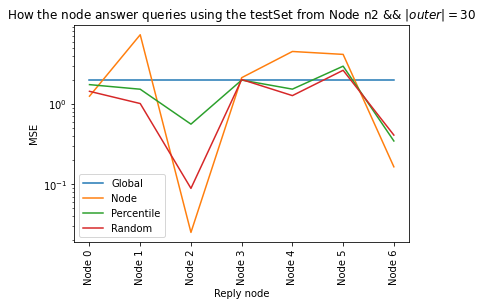

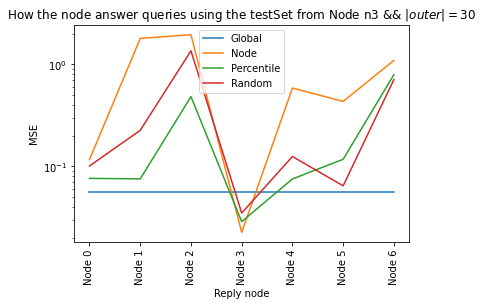

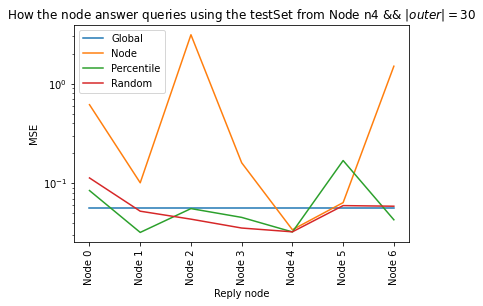

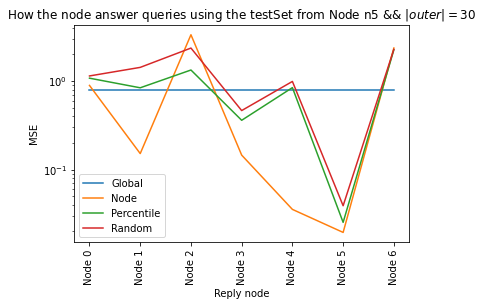

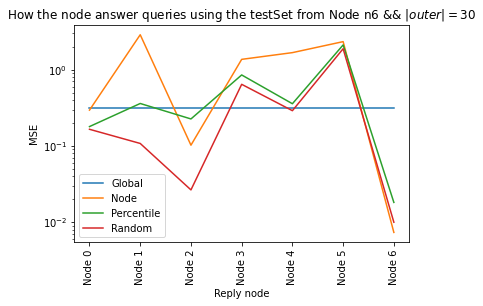

In [44]:
import matplotlib.pyplot as plt

_nodes={}
x=list(range(K))
for o in outersList:
    for test in D_.keys():
        _nodes[o]={}
        
        plt.plot(x, [experiment1[o][test]['full'] for i in range(K)] , label = "Global")
        plt.plot(x, experiment1[o][test]['nodes'] , label = "Node")
        plt.plot(x, experiment1[o][test]['percentile'], label = "Percentile")
        plt.plot(x, experiment1[o][test]['random'], label = "Random")
        plt.title("How the node answer queries using the testSet from Node "
                   +  str(test) + " && $|outer|=$" +str(o))
        plt.ylabel("MSE")
        plt.xlabel("Reply node")
        labels = ["Node "+str(n) for n in x]
        plt.xticks(x, labels, rotation='vertical')
        plt.yscale("log")
        plt.legend()
        plt.show()

{   5: {   'n0': {   'nodes': [   0.024533801798687326,
                                  1.9341989937588886,
                                  1.2521571057517666,
                                  0.1166917136308455,
                                  0.6157775763089732,
                                  0.8935732470865124,
                                  0.2945880817357691],
                     'percentile': [   0.027944912855560094,
                                       0.9596904354536175,
                                       1.4824109034531612,
                                       0.07710286761362999,
                                       0.39402843742341953,
                                       0.8865404789997282,
                                       0.2799773401311352],
                     'random': [   0.027967057231364126,
                                   0.9521093523095403,
                                   1.5255517294412495,
                                  

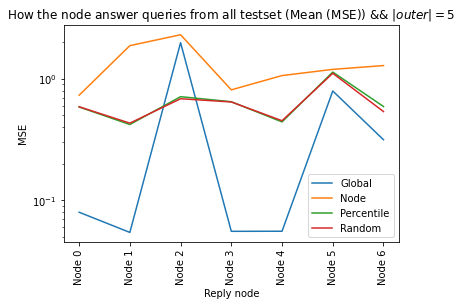

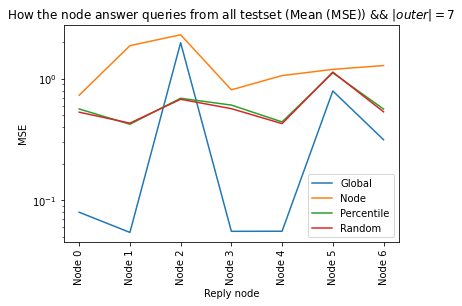

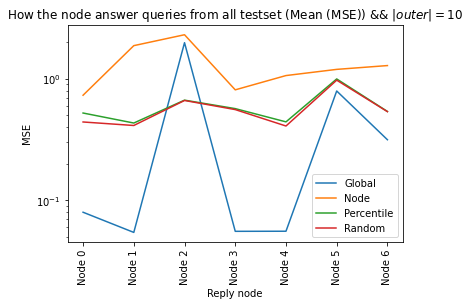

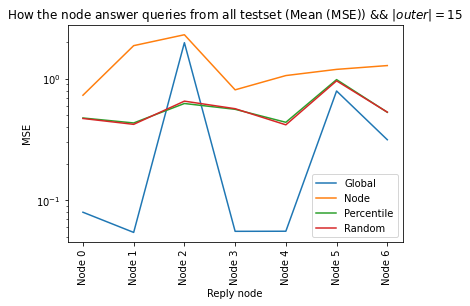

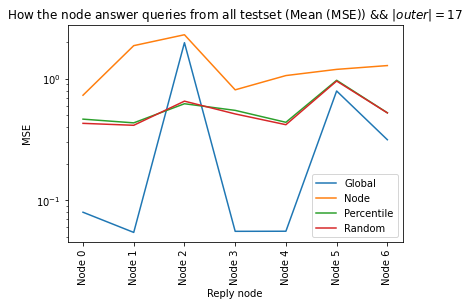

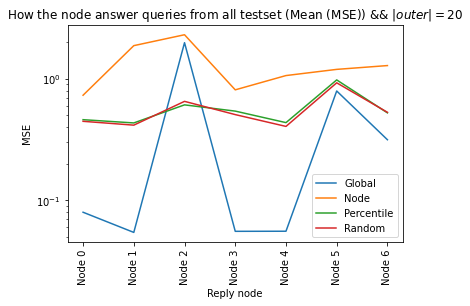

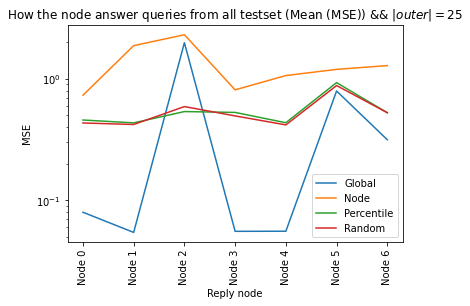

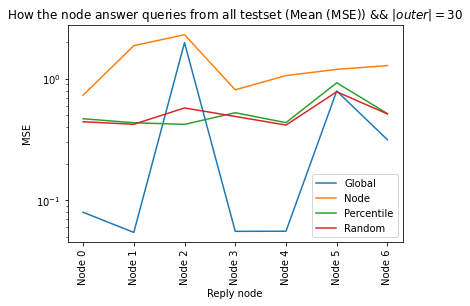

In [51]:
_nodes={}
for o in outersList:
    _nodes[o]={}
  
    for z in D_.keys(): 
        _nodes[o][z]={}
        _nodes[o][z]['nodes']=[]
        _nodes[o][z]['percentile']=[]
        _nodes[o][z]['random']=[]
        
    for k in D_.keys(): 
        ik1=0
        for k1 in D_.keys(): 
            _nodes[o][k1]['nodes'].append(experiment1[o][k]['nodes'][ik1])
            _nodes[o][k1]['percentile'].append(experiment1[o][k]['percentile'][ik1])
            _nodes[o][k1]['random'].append(experiment1[o][k]['random'][ik1])
            ik1=ik1+1
            
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(_nodes)

from functools import reduce
  
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)

x=list(range(K))
for o in outersList:
        #_res = experiments[outer][test]
        mean_nodes=[]
        mean_percentile=[]
        mean_random=[]
        full=[]
        for k in D_.keys():
            mean_nodes.append(Average(_nodes[o][k]['nodes']))
            mean_percentile.append(Average(_nodes[o][k]['percentile']))
            mean_random.append(Average(_nodes[o][k]['random']))
            full.append(experiment1[o][k]['full'])
        
              
        plt.plot(x, full , label = "Global")
        plt.plot(x, mean_nodes , label = "Node")
        plt.plot(x, mean_percentile, label = "Percentile")
        plt.plot(x, mean_random, label = "Random")
        plt.title("How the node answer queries from all testset (Mean (MSE)) && $|outer|=$" +str(o))
        plt.ylabel("MSE")
        plt.xlabel("Reply node")
        labels = ["Node "+str(n) for n in x]
        plt.xticks(x, labels, rotation='vertical')
        plt.yscale("log")
        plt.legend()
        plt.show()